In [ ]:
!pip install wikipedia setuptools pywikibot mwparserfromhell pandas numpy scipy nltk tqdm seaborn pyqt5 pyqtwebengine ruamel-yaml lxml

In [2]:
import wikipedia
import re
import pywikibot
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
import json

In [2]:
wikipedia.set_lang("en")  #We make our research in english

## Creation of a dataframe with the historic references of a wikipedia page

In [3]:
%%time
page_title = "Effects of climate change" # Change this value according to the article you want to scrape revisions from
site = pywikibot.Site("en", "wikipedia")
print('Getting all revisions for {}'.format(page_title))
page = pywikibot.Page(site, page_title)
rev_gen = page.revisions(content=True)
revisions = list(rev_gen)
print('Done!')
print('Number of revisions: {}'.format(str(len(revisions))))
df = pd.DataFrame(revisions)
df = df[['parentid', 'revid', 'size', 'text', 'timestamp']]
df.head()

Getting all revisions for Effects of climate change


Done!
Number of revisions: 6159
Wall time: 3min 16s


,parentid,revid,size,text,timestamp
0,1168184265,1168411180,172751,{{good article}}\n{{short description|Effects ...,2023-08-02 16:02:50
1,1168158084,1168184265,172843,{{good article}}\n{{short description|Effects ...,2023-08-01 08:08:04
2,1167785800,1168158084,172892,{{good article}}\n{{short description|Effects ...,2023-08-01 04:03:09
3,1167262922,1167785800,171906,{{good article}}\n{{short description|Effects ...,2023-07-29 21:49:09
4,1167211717,1167262922,171912,{{good article}}\n{{short description|Effects ...,2023-07-26 18:22:24


In [4]:
# Run to limit versions, here only versions earlier that may 2021. you add the line in the df.
# df =  df.loc[617:,]

In [5]:
df = df[~df.timestamp.dt.date.duplicated()]

#### definition of the function for the extraction of citation

In [ ]:
# Some additional functions
def get_ids_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a doi or a pmid or a pmc and if it's the case the return it 
    Also returns the name of the journal in which the article has been published
    
    param ref : the string of a reference
    
    return ids:  a dictionnary containing the doi or pmid or pmc and the journal of the reference if it's a scientific reference
    '''
    
    d = dict(re.findall(r'(doi|pmc|pmid)(?:(?:\s?[=\|]\s?)|(?:\.)|(?:(?:])*?:)|(?:\s|\/)|(?: *=))([^|\s}]*)', ref))
    if d!={}:
        recode=re.findall(r'(journal of (?:\w| )*)',ref)+re.findall(r"''\[{2}(.*)\]{2}''",ref)+re.findall(r'(?:journal) *?=((?:\w| |\[|-|\.)*)',ref) 
        if recode!= []:
            d["journal"]= recode
            #print(d["journal"],ref)
        recodeaccess =re.findall(r'doi-access *?=((?:\w| )*)',ref)
        if recodeaccess!= []:
            d["access"]= recode
        
        
    ids = {k: v for k, v in d.items() if v}    
    return ids

#filtering way of getting the citations        
def get_citations(wikicode : str)-> dict:
    '''
    param  wikicode: a string containing the wikicode of the page or section of which we want to extract the code
    
    return a dictionnary containing all the information about the citation we want to extract
    '''
    #detection of the citations in the wikicode
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>((?:.|\s)*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations: 
        i+=1
        s.update(c.split('<br/>'))
        
    #Creation of a dataframe containing the citation    
    ds = pd.DataFrame(s, columns=['ref'])
    ds["ref"] = ds["ref"].apply(lambda x : x.replace("\n", " "))
    ds["ref_without_space"] = ds["ref"].apply(lambda x : x.replace(" ", ""))
    ds["ref_without_space"] =  ds["ref_without_space"].apply(lambda x : x.strip())
    ds = ds[(~ds['ref_without_space'].duplicated())]
    
    ds['scientific_ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['scientific_ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['scientific_ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['scientific_ids'].apply(lambda x: x.get('pmc', None))
    ds["journal"]=ds['scientific_ids'].apply(lambda x: x.get('journal', None))    
    ds["journal"] =ds["journal"].apply(lambda x: x[0] if type(x)== list else x)
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]

    ds['IP_guar_ipbes']=ds['ref'].apply(get_IPCC_guardian_ipbes_from_ref)
    ds['IPCC'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('IPCC', None))
    ds['ipbes'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('ipbes', None))
    ds['guard'] = ds['IP_guar_ipbes'].apply(lambda x: x.get('guardian', None))

    ds['site'] = ds['ref'].apply(get_cit_from_ref)
    ds['org'] = ds['site'].apply(lambda x: x.get('org', None))
    ds['gov'] = ds['site'].apply(lambda x: x.get('gov', None))
    ds['com'] = ds['site'].apply(lambda x: x.get('com', None))
    ds['ncbi'] = ds['site'].apply(lambda x: x.get('ncbi.nlm.nih.gov', None))
    
    dic = {'Ref count': ds.shape[0],
           'Ref' : ds['ref'],
           'journal_count': ds[(~ds['journal'].isnull())].shape[0]+ ds[(~ds['ncbi'].isnull())].shape[0],
           'ref_without_space' : ds["ref_without_space"],
           'nb_journal_citations': (ds[(~ds['ncbi'].isnull())]).shape[0]+ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],
           "citationjournal":list(list(ds["doi"])+list(ds["pmid"])+list(ds["pmc"])+list(ds["ncbi"])),
           "citations.org": ds[(~ds['org'].isnull())].shape[0],
           "citations.gov": ds[(~ds['gov'].isnull())].shape[0],
           "citationgovtext":list(ds[(~ds['gov'].isnull())]["gov"]),
           "citationorgtext":list(ds[(~ds['org'].isnull())]["org"]),
           "citationsIPCC.ch": ds[(~ds['IPCC'].isnull())].shape[0],
           "list_IPCC" : list(ds[(~ds['IPCC'].isnull())]["ref"]),
           "ids" : list(ds[(~ds['scientific_ids'].isnull())]["scientific_ids"]),
           "citationcomtext":list(ds[(~ds['com'].isnull())]["com"]),
           "journal": list(ds[(~ds['journal'].isnull())]["journal"])+list(ds[(~ds['ncbi'].isnull())]),
           "citations.com": ds[(~ds['com'].isnull())].shape[0],
           "citationsipbes": ds[(~ds['ipbes'].isnull())].shape[0],
           "citationguardian": ds[(~ds['guard'].isnull())].shape[0]}
    
    return dic

In [ ]:
def get_cit_from_ref(ref: str)-> dict:
    '''
    detects if the reference entering this program contains a.org, .gov or .com citation except if it's a guardian citation
    
    param ref : the string of a citation
    
    return ids:  a dictionnary containing as keys org, gov and com and in values the name of the site of the citation
    '''
    d = dict(re.findall(r"((?:[(?:\.)(?:\-)\w]*)\.(org|com|gov))", ref, flags=re.IGNORECASE))
    
    #remove the archive because we don't want to count them in the number of .org citation
    if 'archive.org' in d :
        d.pop('archive.org', None)
    if "web.archive.org" in d:
        d.pop('web.archive.org', None)
    if "www.webcitation.org" in d:
        d.pop('www.webcitation.org', None)
    if "ghostarchive.org" in d:
        d.pop("ghostarchive.org", None)
    if "www.ncbi.nlm.nih.gov" in d or "ncbi.nlm.nih.gov" in d:
        d.pop("www.ncbi.nlm.nih.gov", None)
        d.pop("ncbi.nlm.nih.gov",None)
        d["ncbi"]="ncbi.nlm.nih.gov"
        
        
    ids = {v: k for k, v in d.items() if v}
    
    return ids

In [ ]:
def get_IPCC_guardian_ipbes_from_ref(ref: str) -> dict:
    '''
    detects if the reference entering this program is an IPCC, ipbes or guardian citation
    
    param ref : the string of a citation
    
    return :  a dictionnary containing as keys guardian, ipbes and IPCC and in values the name of the citation extracted
    '''
    g={}
    citation=list(set(re.findall(r"(ipcc|ipbes|guardian)", ref, flags=re.IGNORECASE)))
    if citation !=None and citation !=[]:
        if "ipcc" in citation:
            g["IPCC"]=ref
        if "ipbes" in citation:
            g["ipbes"]=ref
        if "guardian" in citation:
            g["guardian"]=ref
    return g 

## Get the citations

In [ ]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))

print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])

print("getting the number of scientific citations")
df['nb_scientific_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])
df["journal"] = df['citations'].progress_apply(lambda x: x['journal'])
df["nbjournaldetected"]=df['citations'].progress_apply(lambda x: x['journal_count'])



print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])

print("getting the .com citations")
df["citation com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])

print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

df["list_IPCC"]=df['citations'].progress_apply(lambda x: x["ids"])
df["citationtext_total"]=df["citationgovtext"]+df["citationcomtext"]+df["citationorgtext"]+df["journal"]

df["org count"]=df["citation org"]/df["Ref count"]
df["gov count"]=df["citation gov"]/df["Ref count"]
df["com count"]=df["citation com"]/df["Ref count"]
df["Sci count"]=df['nb_scientific_citations']/df['Ref count']
df['IPCC count']=df['citation IPCC']/df['Ref count']
df['percentage of official sources']=(df['nb_scientific_citations']+ df['citation gov']+ df['citation org']+df['citation IPCC']+df['citationipbes'])/df['Ref count']


print('Done!')
df.head()

In [ ]:
df.set_index("timestamp",inplace=True)

In [53]:
df.index = pd.to_datetime(df.index)

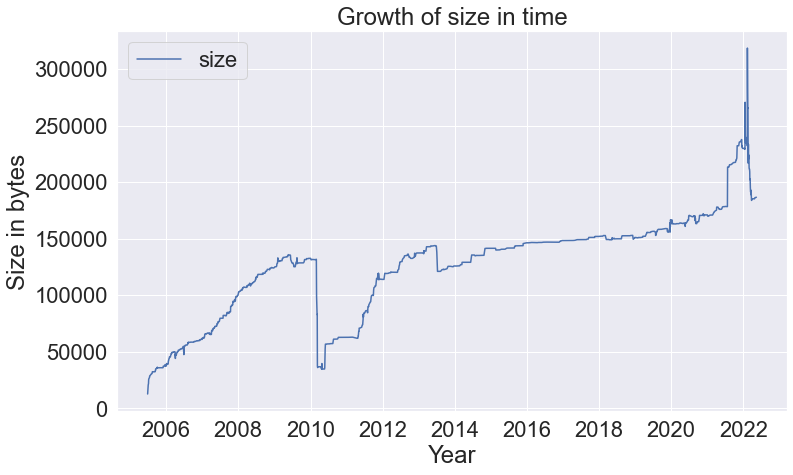

In [54]:
ax=sns.lineplot(data=[df["size"]]).set(title='Growth of size in time',xlabel='Year',ylabel='Size in bytes')

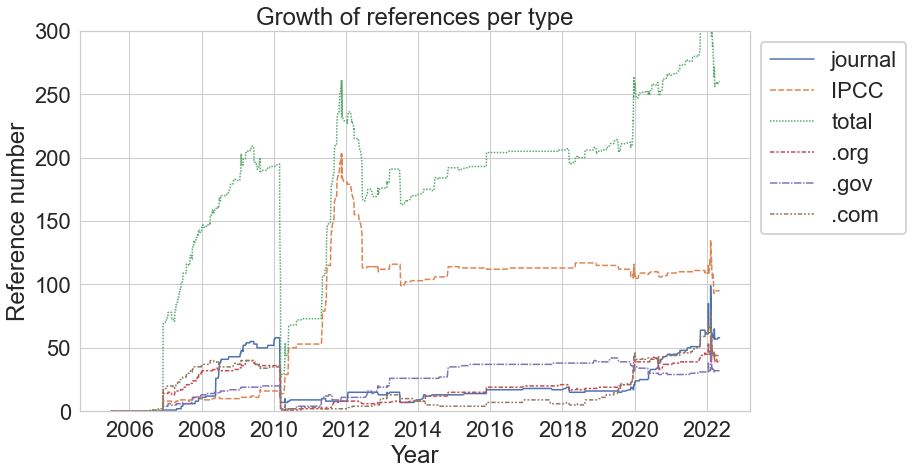

In [55]:
sns.set_style("whitegrid")
ax=sns.lineplot(data=[df["nb_scientific_citations"],df["citation IPCC"],df["Ref count"],df["Ref count"],df["citation org"],df["citation gov"],df['citation com']]).set(title='Growth of references per type',ylim=(0, 300),xlabel='Year',ylabel='Reference number')
sns.set_context("poster")
plt.legend(["journal","IPCC","total", ".org", ".gov",".com"],loc=2,bbox_to_anchor=(1,1))
sns.set(rc={"figure.figsize":(12,7)})
sns.set(font_scale=2)
plt.savefig('evolution of citation.png')

pourcentage of scientific references where we manage to get the name of the journal:

In [56]:
df["nbjournaldetected"].sum()/df["nb_scientific_citations"].sum()

0.9006001895335369

#### Clean and export the dataframes to csv

In [57]:
del df['citationorgtext']
del df['citationgovtext']
del df['text']
del df["citations"]
del df["citationcomtext"]

In [ ]:
#extract the data frame to csv
df.to_csv('historicdata.csv')